# ROI (Region of Interest) Exploration

## Purpose
This notebook helps tune and validate the Region of Interest mask for lane detection. The ROI mask filters out irrelevant parts of the image (sky, trees, side objects) and focuses on the road area where lane lines appear.

## Workflow
1. **Load selected test frames** - 8 specific frames with various road conditions
2. **Define ROI mask function** - Trapezoidal mask with adjustable parameters
3. **Test on single frame** - Quick validation of mask shape and position
4. **Apply to all test frames** - Visualize ROI on all 8 frames to ensure consistency
5. **Tune parameters** - Adjust ratios until mask fits well across all scenarios

## Goal
Find ROI parameters that work well across different road curves, traffic, and camera angles.

## 1. Import Libraries

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import math

## 2. Helper Functions

In [10]:
def show(img, title="", size=8):
    """Display a single image with error handling"""
    if img is None:
        print(f"Error: Cannot display image '{title}' - image is None")
        return
    
    plt.figure(figsize=(size, size))
    if len(img.shape) == 2:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

## 3. Load ROI Test Frames
Using specific frames selected from `01_explore_frames.ipynb`

In [11]:
frames_dir = "../data/frames_sample"

# Exact filenames from 01_explore_frames.ipynb
ROI_FRAME_NAMES = [
    "frame_t109_f6540.png",   # [2]
    "frame_t12_f720.png",     # [5]
    "frame_t186_f11160.png",  # [9]
    "frame_t1_f60.png",       # [12]
    "frame_t243_f14580.png",  # [18]
    "frame_t287_f17220.png",  # [23]
    "frame_t294_f17640.png",  # [29]
    "frame_t9_f540.png"       # [35]
]

# Build full paths
ROI_FRAME_PATHS = [os.path.join(frames_dir, name) for name in ROI_FRAME_NAMES]

# Verify all files exist
print(f"ROI Test Frames ({len(ROI_FRAME_PATHS)} frames):")
print("=" * 60)
all_exist = True
for i, (name, path) in enumerate(zip(ROI_FRAME_NAMES, ROI_FRAME_PATHS)):
    exists = os.path.exists(path)
    status = "✓" if exists else "✗ MISSING"
    print(f"  {status} [{i}] {name}")
    if not exists:
        all_exist = False

if all_exist:
    print("\n✓ All frames found successfully!")
else:
    print("\n⚠️ Warning: Some frames are missing!")

ROI Test Frames (8 frames):
  ✓ [0] frame_t109_f6540.png
  ✓ [1] frame_t12_f720.png
  ✓ [2] frame_t186_f11160.png
  ✓ [3] frame_t1_f60.png
  ✓ [4] frame_t243_f14580.png
  ✓ [5] frame_t287_f17220.png
  ✓ [6] frame_t294_f17640.png
  ✓ [7] frame_t9_f540.png

✓ All frames found successfully!


## 4. Define ROI Mask Function
Creates a trapezoidal mask to isolate the road area

In [12]:
def apply_roi_mask(frame,
                   top_y_ratio=0.60,
                   left_bottom_ratio=0.05,
                   right_bottom_ratio=0.95,
                   top_left_x_ratio=0.40,
                   top_right_x_ratio=0.60):
    """
    Apply trapezoidal ROI mask to focus on road area
    
    Parameters:
        frame: Input image
        top_y_ratio: Height of top edge (0.0=top, 1.0=bottom)
        left_bottom_ratio: Left bottom corner x position (ratio of width)
        right_bottom_ratio: Right bottom corner x position (ratio of width)
        top_left_x_ratio: Top left corner x position (ratio of width)
        top_right_x_ratio: Top right corner x position (ratio of width)
    
    Returns:
        masked: Masked image
        pts: Trapezoid vertices (for visualization)
    """
    h, w = frame.shape[:2]

    # Define trapezoid vertices (bottom-left, bottom-right, top-right, top-left)
    pts = np.array([[
        (int(w * left_bottom_ratio),  h),
        (int(w * right_bottom_ratio), h),
        (int(w * top_right_x_ratio),  int(h * top_y_ratio)),
        (int(w * top_left_x_ratio),   int(h * top_y_ratio)),
    ]], dtype=np.int32)

    # Create mask
    mask = np.zeros_like(frame)
    cv2.fillPoly(mask, pts, (255, 255, 255))

    # Apply mask
    masked = cv2.bitwise_and(frame, mask)
    return masked, pts

## 5. Test ROI on Single Frame
Quick validation on the first test frame

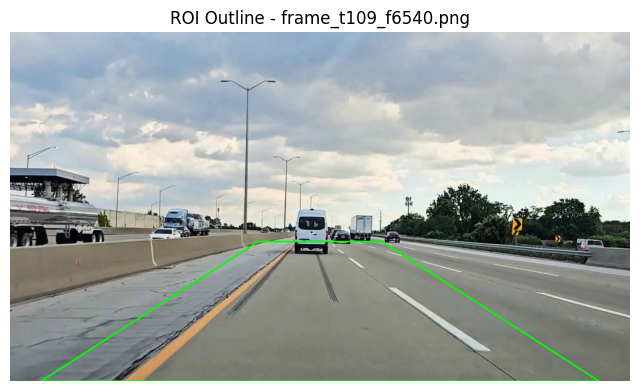

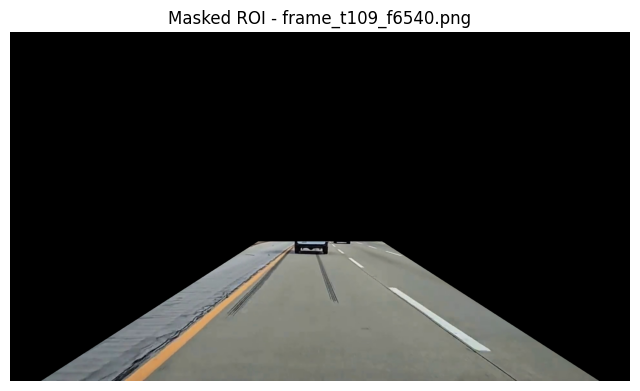

In [13]:
# Load first frame
frame = cv2.imread(ROI_FRAME_PATHS[0])

if frame is None:
    print(f"Error: Could not load {ROI_FRAME_NAMES[0]}")
    print(f"Path: {ROI_FRAME_PATHS[0]}")
else:
    # Apply ROI mask
    masked, roi_pts = apply_roi_mask(frame)
    
    # Create visualization with ROI outline
    vis = frame.copy()
    cv2.polylines(vis, roi_pts, True, (0, 255, 0), 3)
    
    # Display results
    show(vis, f"ROI Outline - {ROI_FRAME_NAMES[0]}")
    show(masked, f"Masked ROI - {ROI_FRAME_NAMES[0]}")

## 6. Visualize ROI on All Test Frames
Display all 8 frames with ROI overlays to validate consistency

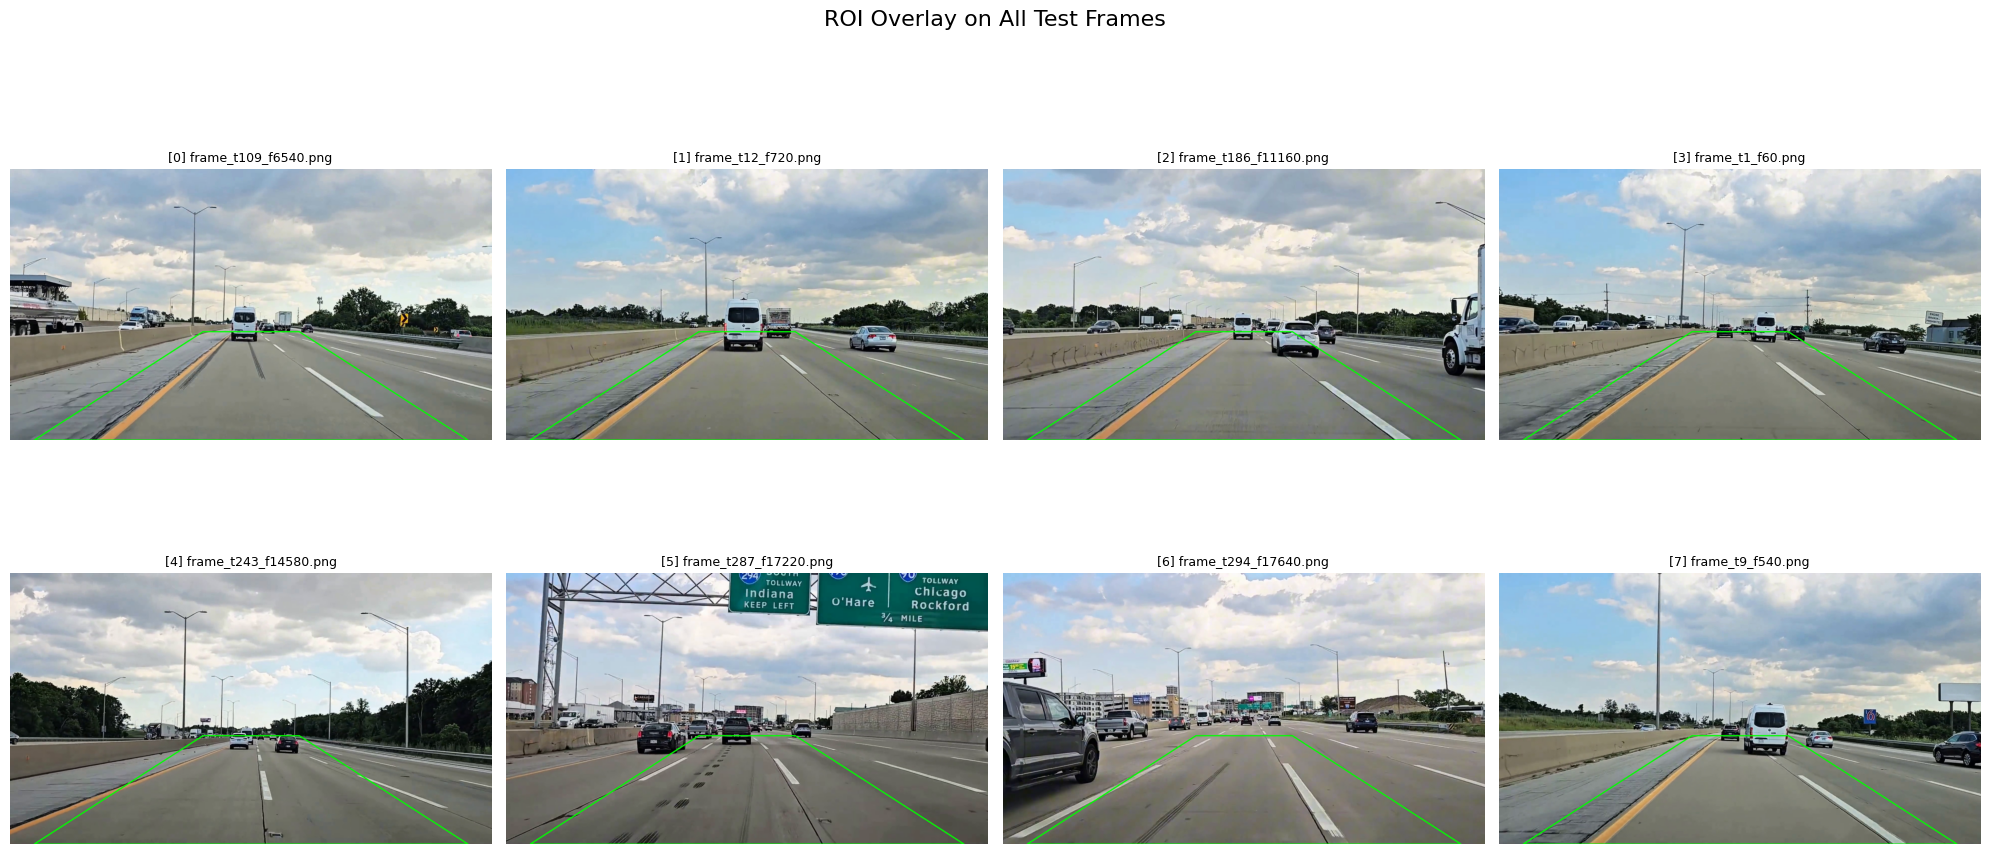

In [ ]:
rows = 2
cols = 4

# Get current ROI parameters
import inspect
sig = inspect.signature(apply_roi_mask)
defaults = {k: v.default for k, v in sig.parameters.items() if v.default != inspect.Parameter.empty}

fig, axes = plt.subplots(rows, cols, figsize=(20, 10))
axes = axes.flatten()

for idx, (path, name) in enumerate(zip(ROI_FRAME_PATHS, ROI_FRAME_NAMES)):
    frame = cv2.imread(path)
    
    if frame is None:
        print(f"Warning: Could not load {name}")
        continue
    
    # Apply ROI and draw outline
    masked, roi_pts = apply_roi_mask(frame)
    vis = frame.copy()
    cv2.polylines(vis, roi_pts, True, (0, 255, 0), 3)
    
    # Display
    axes[idx].imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    axes[idx].set_title(f"[{idx}] {name}", fontsize=9)
    axes[idx].axis('off')

# Add parameters to title
param_text = f"top_y={defaults['top_y_ratio']:.2f} | bottom: L={defaults['left_bottom_ratio']:.2f}, R={defaults['right_bottom_ratio']:.2f} | top: L={defaults['top_left_x_ratio']:.2f}, R={defaults['top_right_x_ratio']:.2f}"
plt.suptitle(f"ROI Overlay on All Test Frames\n{param_text}", fontsize=14, y=0.99)
plt.tight_layout()
plt.show()

## 7. Show Masked Results
View the actual masked images (what the algorithm will see)

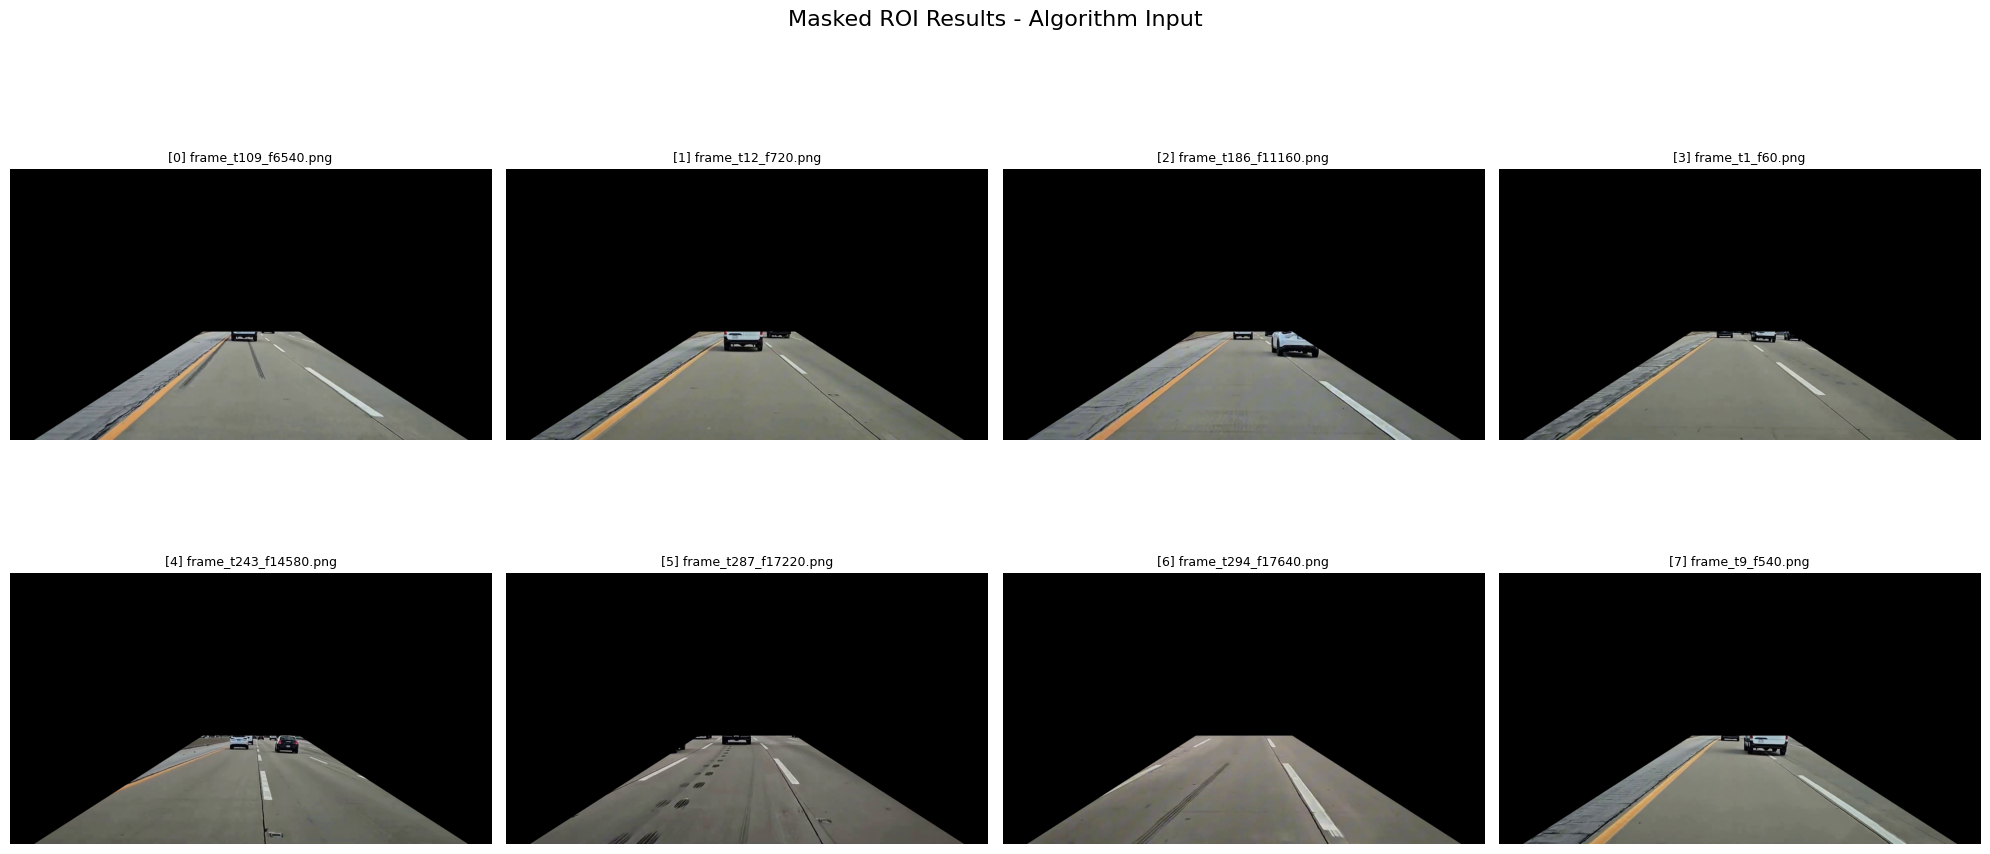

In [ ]:
rows = 2
cols = 4

# Get current ROI parameters
import inspect
sig = inspect.signature(apply_roi_mask)
defaults = {k: v.default for k, v in sig.parameters.items() if v.default != inspect.Parameter.empty}

fig, axes = plt.subplots(rows, cols, figsize=(20, 10))
axes = axes.flatten()

for idx, (path, name) in enumerate(zip(ROI_FRAME_PATHS, ROI_FRAME_NAMES)):
    frame = cv2.imread(path)
    
    if frame is None:
        print(f"Warning: Could not load {name}")
        continue
    
    # Apply ROI mask
    masked, roi_pts = apply_roi_mask(frame)
    
    # Display masked result
    axes[idx].imshow(cv2.cvtColor(masked, cv2.COLOR_BGR2RGB))
    axes[idx].set_title(f"[{idx}] {name}", fontsize=9)
    axes[idx].axis('off')

# Add parameters to title
param_text = f"top_y={defaults['top_y_ratio']:.2f} | bottom: L={defaults['left_bottom_ratio']:.2f}, R={defaults['right_bottom_ratio']:.2f} | top: L={defaults['top_left_x_ratio']:.2f}, R={defaults['top_right_x_ratio']:.2f}"
plt.suptitle(f"Masked ROI Results - Algorithm Input\n{param_text}", fontsize=14, y=0.99)
plt.tight_layout()
plt.show()